# Skip-Gram模型

## 导入包

In [1]:
import time
import numpy as np
import tensorflow as tf
import random
from collections import Counter

## 加载数据

In [6]:
with open("data/text8.txt",encoding="utf-8")as f:
          text = f.read()

## 数据预处理

In [30]:
# 定义函数来完成数据的预处理
def preprocess(text,freq = 5):
    """
    对文本进行预处理
    
    参数
    ---
    text:文本数据
    freq:词频阈值
    """
    #对文本中的符号进行替换
    text = text.lower()
    text = text.replace("."," <PERIOD> ")
    text = text.replace(","," <COMMA> ")
    text = text.replace('"'," <QUOTATION_MARK> ")
    text = text.replace(";"," <SEMICOLON> ")
    text = text.replace("!"," <EXCLAMATION_MARK> ")
    text = text.replace("?"," <QUESTION_MARK> ")
    text = text.replace("("," <LEFT_PAREN> ")
    text = text.replace(")"," <RIGHT_PAREN> ")
    text = text.replace("--"," <HYPHENS> ")
    text = text.replace(":"," <COLON> ")
    words = text.split()
    
    # 删除低频词，减少噪音影响
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word]>freq]
    return trimmed_words

In [31]:
words = preprocess(text)

## 查看筛选后的单词数

In [34]:
print("原单词数：{}".format(len(words)))
print("筛选后的单词数：{}".format(len(set(words))))


原单词数：16680599
筛选后的单词数：63641


## 构建单词映射表

In [38]:
# 整形编码
vocab = set(words)
vocab_to_int = {w:i for i,w in enumerate(vocab)}
int_to_vocab = {i:w for i,w in enumerate(vocab)}

## 查看单词映射表

In [42]:
print("{}的整形编码为{}".format("anarchism",vocab_to_int["anarchism"]))
print("{}表示{}".format(4732,int_to_vocab[4732]))

anarchism的整形编码为21175
4732表示ov


## 对原文进行vocab到int的转换

In [41]:
print("原文：",words[:30])
int_words = [vocab_to_int[word] for word in words]
print(int_words[:30])

原文： ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']
[21175, 54489, 3004, 17834, 60666, 63196, 10739, 61785, 9234, 27854, 60492, 31774, 40864, 18129, 4285, 43796, 4819, 63196, 43796, 17263, 31216, 22113, 43796, 18471, 60213, 63196, 43796, 13904, 31216, 45958]


## 采样
#### 对停用词进行采样，例如"the","or"等停用词，剔除这些单词以后可以加快我们的训练过程，同时减少训练过程中的噪音
#### 公式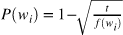

In [51]:
t = 1e-5 # t值
threshold  =0.8 # 剔除概率阈值

#统计单词出现频次
int_word_counts = Counter(int_words)
total_count = len(int_words)
#计算单词频率
word_freqs = {w:int_word_counts[w]/total_count for w in int_word_counts}
#计算被删除的概率
prob_drop =  {w:1 - np.sqrt(t/word_freqs[w]) for w in int_word_counts}
# # 对单词进行采样
train_words = [w for w in int_words if prob_drop[w]<threshold]

In [54]:
len(train_words)

6925252

## 构造batch
#### Skip-Gram模型是通过输入词来预测上下文。因此我们要构造我们的训练样本，具体思想请参考知乎专栏，这里不再重复。
#### 对于一个给定词，离它越近的词可能与它越相关，离它越远的词越不相关，这里我们设置窗口大小为5，对于每个训练单词，我们还会在[1:5]之间随机生成一个整数R，用R作为我们最终选择output word的窗口大小。这里之所以多加了一步随机数的窗口重新选择步骤，是为了能够让模型更聚焦于当前input word的邻近词。

In [60]:
def get_targets(words,idx,window_size=5):
    """
    获得input_word的上下文单词列表
    
    参数
    ---
    words:单词列表
    idx:word的索引号
    wondow_size:窗口大小
    """
    target_window = np.random.randint(1,window_size+1)
    print("随机窗口为：{}".format(target_window))
    # 这里要考虑input word 前面的单词不够的情况
    start_point = idx-target_window if (idx - target_window) > 0 else 0
    end_point = idx + target_window
    #output words(即窗口中的上下文单词)
    targets = set(words[start_point:idx] + words[idx+1:end_point+1])
    return list(targets)

In [63]:
get_targets(words,5)

随机窗口为：4


['as', 'used', 'abuse', 'originated', 'against', 'a', 'term', 'first']

In [67]:
def get_batches(words, batch_size, window_size=5):
    '''
    构造一个获取batch的生成器
    '''
    n_batches = len(words) // batch_size
    
    # 仅取full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx: idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_targets(batch, i, window_size)
            # 由于一个input word会对应多个output word，因此需要长度统一
            x.extend([batch_x]*len(batch_y))
            y.extend(batch_y)
        yield x, y

In [69]:
batch = get_batches(['as', 'used', 'abuse', 'originated', 'against', 'a', 'term', 'first'],3)
next(batch)
next(batch)

随机窗口为：5
随机窗口为：2
随机窗口为：3
随机窗口为：2
随机窗口为：4
随机窗口为：1


(['originated', 'originated', 'against', 'against', 'a'],
 ['against', 'a', 'originated', 'a', 'against'])